In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

In [29]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_adj(alphas,thetas):
    num_nodes = len(alphas)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            norm_diff = np.linalg.norm(thetas[i] - thetas[j])**2
            m_ij = alphas[i] + alphas[j] - norm_diff
            adjacency_matrix[i][j] = np.random.binomial(1, sigmoid(m_ij))
            adjacency_matrix[j][i] = adjacency_matrix[i][j]
    return adjacency_matrix

def distance_matrix(point_theta):
    n = point_theta.shape[0]
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(point_theta[i] - point_theta[j])**2
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

def generate_M_matrix(alphas, thetas):
    num_nodes = len(alphas)
    M = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
            M[i][j] = alphas[i] + alphas[j] - norm_squared
            M[j][i] = M[i][j]
    return M

def f(A, alphas, thetas):
    M = generate_M_matrix(alphas, thetas)
    num_nodes = A.shape[0]
    result = 0
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                sigmoid_M = sigmoid(M[i][j])
                result += A[i][j] * M[i][j] + np.log(1 - sigmoid_M)
    return result

def Projection(X,C):
    return X if np.linalg.norm(X) < C else C*X/np.linalg.norm(X)

def gradient_theta(A, alphas, thetas):
    num_nodes = len(alphas)
    gradient = np.zeros_like(thetas)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
                exp_term = np.exp(alphas[i] + alphas[j] - norm_squared)
                # sigmoid_term = sigmoid(alphas[i] + alphas[j] - norm_squared)

                gradient[i] += -2 * A[i][j] * (thetas[i] - thetas[j]) + \
                                2 * (thetas[i] - thetas[j]) * exp_term / (1 + exp_term)
    return gradient

def gradient_alpha(A, alphas, thetas):
    num_nodes = len(alphas)
    gradient = np.zeros_like(alphas)
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
                exp_term = np.exp(alphas[i] + alphas[j] - norm_squared)
                # sigmoid_term = sigmoid(alphas[i] + alphas[j] - norm_squared)
                gradient[i] += A[i][j] - exp_term / (1 + exp_term)
    
    return gradient

In [30]:
def main(num_samples, k, C, learning_rate, learning_rate_, tolerace):
    # Generate alpha
    true_alpha = np.random.rand(num_samples)
    # true_alpha = np.random.uniform(-1, 1, num_samples)

    # Generate theta method
    true_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # true_theta = np.random.uniform(-1, 1, num_samples*k).reshape(num_samples,-1)

    # Generate adjacency matrix
    adjacency_matrix = generate_adj(true_alpha, true_theta)

    # Generate distance matrix
    distance_matrix_ = distance_matrix(true_theta)

    # pred_alpha = true_alpha
    # pred_theta = true_theta
    
    pred_alpha = np.random.rand(num_samples)
    # pred_alpha = np.random.uniform(-1, 1, num_samples)
    pred_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # pred_theta = np.random.uniform(-1, 1, num_samples*k).reshape(num_samples,-1)

    logli = f(adjacency_matrix, pred_alpha, pred_theta)

    avg_loss_theta = []
    avg_loss_alpha = []
    max_loss_theta = []
    max_loss_alpha = []
    logli_list = []

    # Learning rate adjustment variables
    decay_rate = 0.9  
    min_learning_rate = learning_rate_

    flag = True
    iter = 0
    while flag:
        iter += 1
        # update theta
        grad_y = gradient_theta(adjacency_matrix, pred_alpha, pred_theta)
        prev_theta = pred_theta
        pred_theta = Projection(pred_theta + learning_rate*grad_y, C)
        diff_distance = distance_matrix_-distance_matrix(pred_theta)
        avg_loss_theta.append(np.linalg.norm(diff_distance, ord='fro')**2/len(pred_theta)**2)
        max_loss_theta.append(np.abs(diff_distance).max())  

        # update alpha
        grad_x = gradient_alpha(adjacency_matrix, pred_alpha, pred_theta)
        prev_alpha = pred_alpha
        pred_alpha = Projection(pred_alpha + learning_rate*grad_x, C)
        diff_alpha = true_alpha-pred_alpha
        avg_loss_alpha.append(np.linalg.norm(diff_alpha)**2/len(pred_alpha))
        max_loss_alpha.append(np.abs(diff_alpha).max())

        prev_logli = logli
        logli = f(adjacency_matrix, pred_alpha, pred_theta)
        logli_list.append(prev_logli)

        if (logli-prev_logli)/np.abs(prev_logli) < tolerace:
            flag = False

        # Update the learning rate
        learning_rate = max(min_learning_rate, learning_rate * decay_rate)

    return avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list

In [31]:
def main_(num_samples, k, C, learning_rate, learning_rate_):
    # Generate alpha
    true_alpha = np.random.rand(num_samples)
    # true_alpha = np.random.uniform(-1, 1, num_samples)

    # Generate theta method
    true_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # true_theta = np.random.uniform(-1, 1, num_samples*k).reshape(num_samples,-1)

    # Generate adjacency matrix
    adjacency_matrix = generate_adj(true_alpha, true_theta)

    # Generate distance matrix
    distance_matrix_ = distance_matrix(true_theta)

    # pred_alpha = true_alpha
    # pred_theta = true_theta
    
    pred_alpha = np.random.rand(num_samples)
    # pred_alpha = np.random.uniform(-1, 1, num_samples)
    pred_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # pred_theta = np.random.uniform(-1, 1, num_samples*k).reshape(num_samples,-1)

    logli = f(adjacency_matrix, pred_alpha, pred_theta)

    decay_rate = 0.9  
    min_learning_rate = learning_rate_

    avg_loss_theta = []
    avg_loss_alpha = []
    max_loss_theta = []
    max_loss_alpha = []
    logli_list = []

    iter = 0
    for i in range(10):
        iter += 1

        grad_y = gradient_theta(adjacency_matrix, pred_alpha, pred_theta)
        prev_theta = pred_theta
        pred_theta = Projection(pred_theta + learning_rate*grad_y, C)
        diff_distance = distance_matrix_-distance_matrix(pred_theta)
        avg_loss_theta.append(np.linalg.norm(diff_distance, ord='fro')**2/len(pred_theta)**2)
        max_loss_theta.append(np.abs(diff_distance).max())  

        grad_x = gradient_alpha(adjacency_matrix, pred_alpha, pred_theta)
        prev_alpha = pred_alpha
        pred_alpha = Projection(pred_alpha + learning_rate*grad_x, C)
        diff_alpha = true_alpha-pred_alpha
        avg_loss_alpha.append(np.linalg.norm(diff_alpha)**2/len(pred_alpha))
        max_loss_alpha.append(np.abs(diff_alpha).max())

        prev_logli = logli
        logli = f(adjacency_matrix, pred_alpha, pred_theta)
        logli_list.append(prev_logli)

        # Update the learning rate
        learning_rate = max(min_learning_rate, learning_rate * decay_rate)

    return avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list

In [32]:
# np.random.seed(1)
num_samples = 100
k = 2
C = 10000
learning_rate  = 0.01
learning_rate_ = 0.001
tolerace = 0.0001

avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list = main(num_samples, k, C, learning_rate, learning_rate_, tolerace)
# avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list = main(num_samples, k, C, learning_rate, learning_rate_)

In [33]:
relative_errors = []

for i in range(1, len(logli_list)):
    relative_error = (logli_list[i] - logli_list[i-1])/abs(logli_list[i-1])
    relative_errors.append(relative_error)

print(relative_errors)

[0.16451337604059305, 0.019341731169711253, 0.009312211848812464, 0.006047803303382494, 0.0042944529833153725, 0.003217443473373122, 0.002502854809161591, 0.0020014012826891324, 0.0016342241481415154, 0.0013563073821138206, 0.0011403166568091188, 0.0009688040390156018, 0.0008301673075095685, 0.000716424976744664, 0.000621926917421433, 0.0005425740430888342, 0.0004753283081491386, 0.0004178951421884864, 0.0003685119856648135, 0.00032580413658373137, 0.0002886844471130995, 0.00025628225222761524, 0.00023142023149159255, 0.00022896484913119785, 0.00022658499562692956, 0.00022427861041278204, 0.00022204369746992866, 0.00021987832170399156, 0.00021778060571819733, 0.00021574872689447623, 0.00021378091470577114, 0.00021187544823528064, 0.0002100306539820413, 0.00020824490381604217, 0.00020651661310428052, 0.00020484423906641373, 0.0002032262791383951, 0.00020166126961607868, 0.0002001477843725971, 0.00019868443354010006, 0.00019726986253066343, 0.00019590275094659348, 0.00019458181167877274,

In [34]:
len(relative_errors)

355

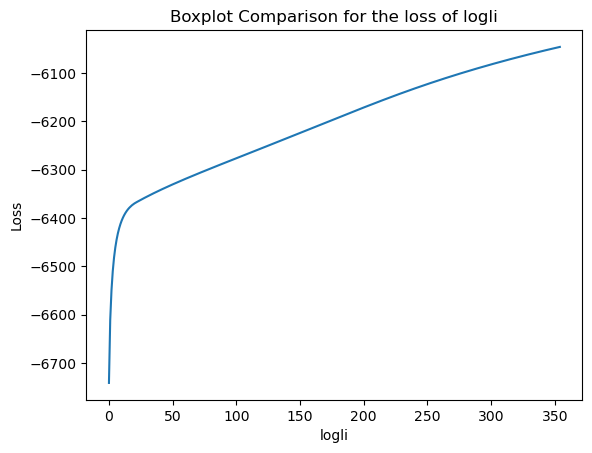

In [35]:
plt.plot(logli_list[1:])
plt.title(fr'Boxplot Comparison for the loss of logli')
plt.xlabel('logli')
plt.ylabel('Loss')
plt.show()

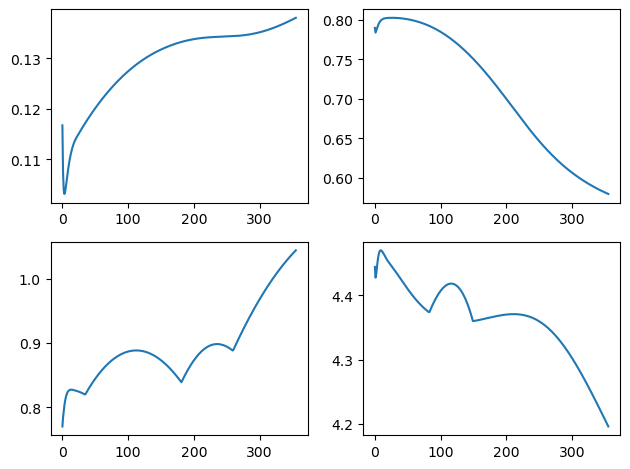

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# 定义四个列表的数据
avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta

# 创建一个 2x2 的子图布局
fig, axs = plt.subplots(2, 2)

# 绘制每个子图的线图
axs[0, 0].plot(avg_loss_alpha)
axs[0, 1].plot(avg_loss_theta)
axs[1, 0].plot(max_loss_alpha)
axs[1, 1].plot(max_loss_theta)

# 调整子图的布局和样式
plt.tight_layout()

# 显示图形
plt.show()